In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

filename = tf.keras.utils.get_file('petfinder_mini.zip', dataset_url, extract=True)
dataframe = pd.read_csv("\\".join(filename.split("\\")[:-1]) + "\\petfinder-mini\\petfinder-mini.csv")

In [3]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [4]:
dataframe['target'] = np.where(dataframe['AdoptionSpeed'] == 4 , 0 , 1)
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


In [5]:
train, test = train_test_split(dataframe, test_size = 0.2)
train, valid = train_test_split(train, test_size = 0.2)
print("train length:", len(train))
print("valid length:", len(valid))
print("test length:", len(test))


train length: 7383
valid length: 1846
test length: 2308


In [6]:
def dataframe_2_dataset(dataframe, shuffle=True, batch=5):
    dataframe = dataframe.copy()
    target = dataframe.pop("target")
   
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), target))
    if(shuffle):
        ds = ds.shuffle(10000)
        
    ds = ds.batch(batch)
    
    return ds

train_ds = dataframe_2_dataset(train, shuffle=False)
valid_ds = dataframe_2_dataset(valid, shuffle=False)
test_ds = dataframe_2_dataset(test, shuffle=False)

In [7]:
for idx, (features, target) in zip(range(1), train_ds):
    print(features)
    print("-" * 80)
    print("target:", target)
    print("=" * 80)
    print("features keys:", list(features.keys()))
    print("types:", features['Type'])
    

{'Type': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Dog', b'Cat', b'Dog', b'Cat', b'Dog'], dtype=object)>, 'Age': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([12,  2, 21,  6,  2], dtype=int64)>, 'Breed1': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'German Shepherd Dog', b'Domestic Medium Hair', b'Shih Tzu',
       b'Domestic Short Hair', b'Mixed Breed'], dtype=object)>, 'Gender': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Female', b'Male', b'Male', b'Female', b'Male'], dtype=object)>, 'Color1': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Black', b'Gray', b'Brown', b'Yellow', b'Brown'], dtype=object)>, 'Color2': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Brown', b'White', b'Cream', b'White', b'Cream'], dtype=object)>, 'MaturitySize': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Large', b'Medium', b'Small', b'Medium', b'Medium'], dtype=object)>, 'FurLength': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Medium', b'Mediu

In [8]:
example_batch = next(iter(train_ds))[0]
print(example_batch['Age'])
print(example_batch['Type'])


tf.Tensor([12  2 21  6  2], shape=(5,), dtype=int64)
tf.Tensor([b'Dog' b'Cat' b'Dog' b'Cat' b'Dog'], shape=(5,), dtype=string)


In [9]:
photo_count = tf.feature_column.numeric_column("PhotoAmt")
photo_count

NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [10]:
def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column, dtype=tf.float32)
    print(feature_layer(example_batch))

print("feature PhotoAmt:")
demo(tf.feature_column.numeric_column("PhotoAmt"))
print("feature Age (numeric):")
demo(tf.feature_column.numeric_column("Age"))
print("feature Age (bucketized):")
age_bucketized = tf.feature_column.bucketized_column(tf.feature_column.numeric_column("Age"), boundaries=[1,2,35,60])
demo(age_bucketized)

feature PhotoAmt:
tf.Tensor(
[[ 1.]
 [11.]
 [ 2.]
 [ 1.]
 [ 4.]], shape=(5, 1), dtype=float32)
feature Age (numeric):
tf.Tensor(
[[12.]
 [ 2.]
 [21.]
 [ 6.]
 [ 2.]], shape=(5, 1), dtype=float32)
feature Age (bucketized):
tf.Tensor(
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(5, 5), dtype=float32)


In [11]:
print("feature Type (indicator):")
animal_type = tf.feature_column.categorical_column_with_vocabulary_list('Type', ['Cat', 'Dog'])
demo(tf.feature_column.indicator_column(animal_type))

feature Type (indicator):
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(5, 2), dtype=float32)


In [12]:
print("feature Breed1 (embedding):")
demo(tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_vocabulary_list("Breed1", dataframe.Breed1.unique()), dimension=4))

feature Breed1 (embedding):
tf.Tensor(
[[ 0.02092875 -0.49208277 -0.52478945  0.21710193]
 [-0.15133893  0.735693   -0.28857002  0.8293971 ]
 [ 0.4135381   0.18187422 -0.2948262  -0.1982875 ]
 [-0.15487541 -0.11795948  0.17699955 -0.26757115]
 [-0.11981515 -0.05752235 -0.26879936  0.7325115 ]], shape=(5, 4), dtype=float32)


In [13]:
print("feature Breed1 (hashed):")
demo(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_hash_bucket("Breed1", hash_bucket_size=10)))

feature Breed1 (hashed):
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]], shape=(5, 10), dtype=float32)


In [15]:
print("crossed features [Type, Age]:")
# demo(tf.feature_column.indicator_column(tf.feature_column.crossed_column([animal_type, age_bucketized], hash_bucket_size=10)))

crossed features [Type, Age]:


--------------------------

In [16]:
feature_columns = []

# --- numeric
for item in ["PhotoAmt", "Fee", "Age"]:
    feature_columns.append(tf.feature_column.numeric_column(item))
    
# --- bucketized
for item in ["PhotoAmt", "Fee", "Age"]:
    feature_columns.append(
        tf.feature_column.bucketized_column(tf.feature_column.numeric_column(item), boundaries = [_ for _ in range(10)])
    )
    
# --- indicator
for item in ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health']:
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(item, dataframe[item].unique())
        )
    )
    
# --- embedding
for item in ['Breed1']:
    feature_columns.append(
        tf.feature_column.embedding_column(
            tf.feature_column.categorical_column_with_vocabulary_list(item, dataframe[item].unique()), 
            dimension=15
        )
    )

feature_columns

[NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)),
 BucketizedColumn(source_column=NumericColumn(key='Fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)),
 BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Type', vocabulary_list=('Cat', 'Dog'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColum

In [17]:
demo(feature_columns)

tf.Tensor(
[[ 1.20000000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.90401271e-01 -3.09805363e-01 -3.97693634e-01  8.75156820e-02
   1.78512111e-01 -1.14762771e-03 -4.69420142e-02 -2.63555050e-01
  -1.21242143e-01  2.36009553e-01  1.48063913e-01 -2.34554783e-01
   1.30425975e-01  7.56044500e-03  2.58954205e-02  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00

In [18]:
features_layer = tf.keras.layers.DenseFeatures(feature_columns)
model = tf.keras.models.Sequential([
    features_layer,
    tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation("sigmoid")
])

# tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy"]
)

In [20]:
train_ds = dataframe_2_dataset(train, batch=16)
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
462/462 [==============================] - 4s 9ms/step - loss: 0.5507 - accuracy: 0.7283 - val_loss: 0.5636 - val_accuracy: 0.7329
Epoch 2/20
462/462 [==============================] - 3s 7ms/step - loss: 0.5428 - accuracy: 0.7311 - val_loss: 0.5327 - val_accuracy: 0.7367
Epoch 3/20
462/462 [==============================] - 3s 7ms/step - loss: 0.5401 - accuracy: 0.7301 - val_loss: 0.5390 - val_accuracy: 0.7329
Epoch 4/20
462/462 [==============================] - 3s 7ms/step - loss: 0.5370 - accuracy: 0.7322 - val_loss: 0.5326 - val_accuracy: 0.7329
Epoch 5/20
462/462 [==============================] - 3s 7ms/step - loss: 0.5354 - accuracy: 0.7318 - val_loss: 0.5304 - val_accuracy: 0.7335
Epoch 6/20
462/462 [==============================] - 3s 7ms/step - loss: 0.5330 - accuracy: 0.7314 - val_loss: 0.5340 - val_accuracy: 0.7329
Epoch 7/20
462/462 [==============================] - 3s 7ms/step - loss: 0.5303 - accuracy: 0.7337 - val_loss: 0.5322 - val_accuracy: 0.7329
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


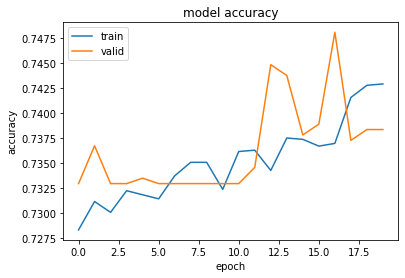

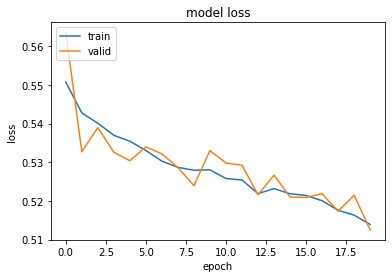

In [21]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [22]:
for idx, (features, label) in zip(range(2), train_ds):
    print (features, label)

{'Type': <tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'Cat', b'Dog', b'Dog', b'Cat', b'Cat', b'Cat', b'Cat', b'Dog',
       b'Cat', b'Dog', b'Cat', b'Dog', b'Cat', b'Dog', b'Cat', b'Cat'],
      dtype=object)>, 'Age': <tf.Tensor: shape=(16,), dtype=int64, numpy=
array([ 48,   5,   9,   4,   4,   1, 108,  20,   3,   2,  12,   3,   1,
         2,  22,  67], dtype=int64)>, 'Breed1': <tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'Burmilla', b'Jack Russell Terrier', b'Shepherd',
       b'Domestic Short Hair', b'Domestic Medium Hair',
       b'Domestic Short Hair', b'Domestic Short Hair', b'Mixed Breed',
       b'Domestic Short Hair', b'Mixed Breed', b'Domestic Medium Hair',
       b'Mixed Breed', b'Tabby', b'Mixed Breed', b'Domestic Short Hair',
       b'Russian Blue'], dtype=object)>, 'Gender': <tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'Female', b'Male', b'Female', b'Male', b'Male', b'Female',
       b'Male', b'Female', b'Male', b'Female', b'Female', b'Female',

In [23]:
features_layer(next(iter(train_ds))[0])

<tf.Tensor: shape=(16, 84), dtype=float32, numpy=
array([[24.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 4.,  0.,  0., ...,  1.,  0.,  0.],
       ...,
       [ 8.,  0.,  0., ...,  0.,  1.,  0.],
       [15.,  0.,  0., ...,  0.,  0.,  1.],
       [ 6.,  0.,  0., ...,  1.,  0.,  0.]], dtype=float32)>

In [25]:
loss, accuracy = model.evaluate(test_ds)
print("loss = {}\naccuracy = {}".format(loss, accuracy))

462/462 [==============================] - 2s 4ms/step - loss: 0.5070 - accuracy: 0.7513
loss = 0.5069625377655029
accuracy = 0.7512997984886169
